In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import standardize
from keras.models import Sequential , model_from_json
from keras.layers.core import Dense, Activation
import keras.optimizers as optimizers
import keras.callbacks as callbacks
from keras import backend as K
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
from iminuit import Minuit
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
%matplotlib inline

In [3]:
data = pd.read_csv('../data/ptZ_ATLAS_2014_5parameters.dat', sep=' ', skiprows=1, header=None)
x = np.array(data.ix[:,:4])
xm = (x-np.mean(x,axis=0))/np.std(x,axis=0)
orig = np.array(data.ix[:,5])
tg = (orig-np.mean(orig))/np.std(orig) #np.vstack([ standardize(bin) for bin in np.array(data.ix[:,5:]).T]).T

In [4]:
def baseline_model(optimizer='rmsprop', init='glorot_uniform'):
    """Build the NN model"""
    model = Sequential()    
    model.add(Dense(output_dim=3, input_dim=5, init=init, activation='sigmoid'))
    model.add(Dense(output_dim=5, input_dim=3, init=init, activation='sigmoid'))    
    model.add(Dense(output_dim=1, input_dim=5, init=init, activation='linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [5]:
seed = 7
np.random.seed(seed)
model = KerasRegressor(build_fn=baseline_model, nb_epoch=10000, batch_size=20, verbose=0)
#kfold = KFold(n_splits=5, random_state=seed)
#results = cross_val_score(model, xm, tg, cv=kfold)
#print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

0.00121821905486


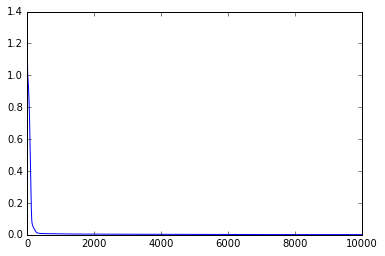

In [6]:
h = model.fit(xm,tg, nb_epoch=10000, batch_size=20)
plt.plot(h.history['loss'])
print h.history['loss'][-1]

In [31]:
seed = 0
np.random.seed(seed)

# model
model = KerasRegressor(build_fn=baseline_model, verbose=0)
optimizers = ['rmsprop', 'sgd']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [1000, 2000, 5000, 10000]
batches = [5, 20, 50, x.shape[0]]
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2,  scoring='neg_mean_squared_error')
grid_result = grid.fit(xm, tg)

# summary
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
means2 = grid_result.cv_results_['mean_train_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, mean2, param in zip(means, stds, means2, params):
    print("%f (%f) %f %f with: %r" % (mean, stdev, mean2, mean/mean2, param))

KeyboardInterrupt: 

In [399]:
model = grid_result.best_estimator_

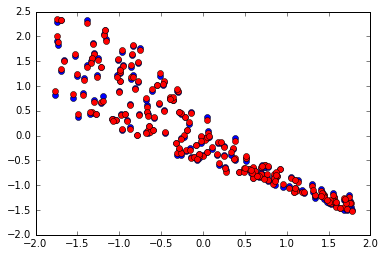

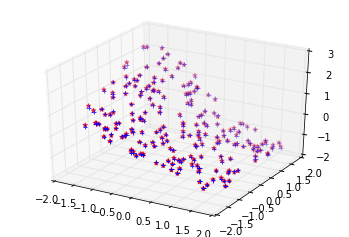

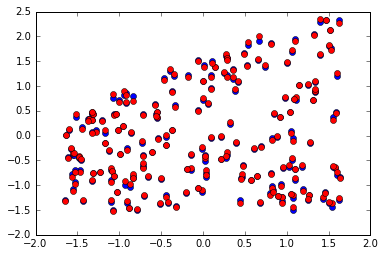

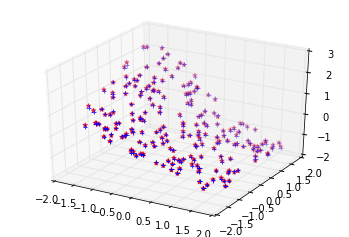

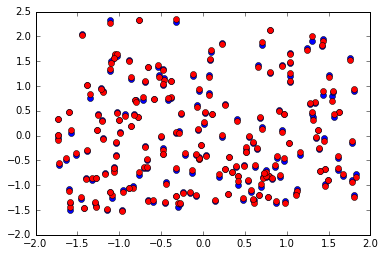

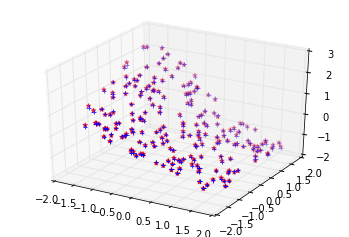

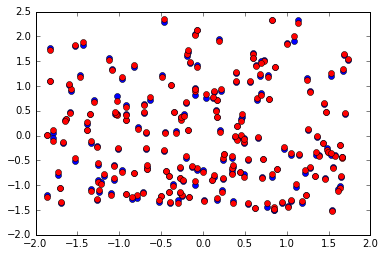

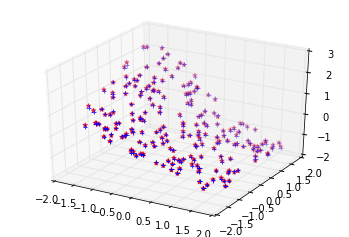

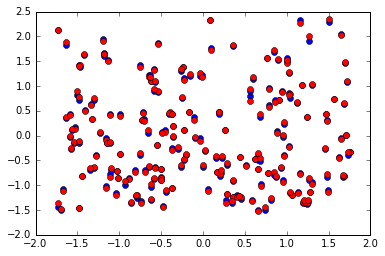

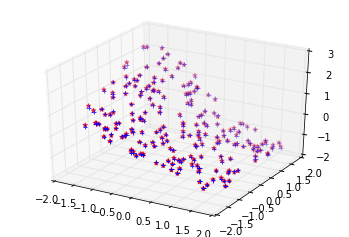

In [7]:
for i in range(5):
    plt.figure()
    plt.plot(xm[:,i], tg, marker='o', linestyle='none')
    plt.plot(xm[:,i], model.predict(xm), 'o', color='r')
    fig = plt.figure()        
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xm[:,0], xm[:,1], tg, marker='+')
    ax.scatter(xm[:,0], xm[:,1], model.predict(xm), marker='*', color='r')        

In [63]:
p = model.predict(xm)
for i in range(len(tg)):
    print tg[i], p[i]

1.38374822893 1.38585
-1.44190670035 -1.42403
0.664398956006 0.682796
-1.02217671777 -1.04837
0.371695741883 0.392044
0.226123225927 0.245867
-1.2602008776 -1.22995
-0.780370117556 -0.816386
-0.026173132019 -0.00992322
-0.662394322678 -0.615525
-1.24337250972 -1.21245
-0.688975033862 -0.693082
1.13937344407 1.17786
-0.384111991047 -0.383638
-0.745624531588 -0.774024
0.789662538042 0.75206
-0.816936711648 -0.815951
-1.19432769211 -1.16152
-0.648174689743 -0.649764
-0.452536089767 -0.441741
0.874652178721 0.890339
1.09927446968 1.12371
-1.37431613525 -1.34499
-0.814795806838 -0.756509
-0.146307854056 -0.119683
2.05588645821 2.03501
-0.315133705112 -0.30267
-0.623414235754 -0.608466
-0.0265944044143 -0.0246973
-0.485357790036 -0.443116
-0.467852833164 -0.474484
0.618715306386 0.591691
-1.49981325688 -1.44394
-0.0407554647163 -0.057086
1.0802789144 1.09719
-0.507446430867 -0.448937
0.0523592513929 0.100292
-1.32174945038 -1.32516
-0.265058609918 -0.246304
-0.687120233833 -0.671727
-0.74038

In [409]:
def f(x0,x1,x2,x3,x4):    
    #fun = model.predict(z.reshape((1,5)))
    fun = model.predict(np.array([x0,x1,x2,x3,x4]).reshape((1,5)))
    truth = model.predict(xm[0].reshape((1,5))) # model number 0
    return np.sum(np.square( (truth-fun) / truth))

In [410]:
s0max = np.max(xm, axis=0)
s0min = np.min(xm, axis=0)
bounds = [(low,high) for low, high in zip(s0min,s0max)]

fargs = dict()
for i in range(5):
    fargs['x%d' % i] = 0
    fargs['error_x%d' % i] = 1
    fargs['limit_x%d' % i] = bounds[i]

m = Minuit(f, errordef=1, **fargs)
m.strategy = 2
m.tol = 1e-5
m.migrad()
print xm[0]

FCN = 3.80672715572e-11 
 TOTAL NCALL = 699 
 NCALLS = 699 
 
 
 EDM = 4.67827639316e-10 
 GOAL EDM = 1e-09 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,-7.663344e-01,7.632135e-01,0.000000e+00,0.000000e+00,-1.76279353909,1.77637462602,
2,x1,7.834217e-01,2.516952e+00,0.000000e+00,0.000000e+00,-1.64284662191,1.6415217465,
3,x2,1.058851e+00,3.174544e+00,0.000000e+00,0.000000e+00,-1.73141745946,1.82798729615,
4,x3,5.519568e-01,1.990660e+00,0.000000e+00,0.000000e+00,-1.86843346197,1.73042002577,
5,x4,1.688331e+00,1.749630e+00,0.000000e+00,0.000000e+00,-1.73091745449,1.75191570803,


[-0.86070702  0.73861176 -0.5343571  -0.82876508 -1.47173935]


In [412]:
m.print_matrix()

+,x0,x1,x2,x3,x4
x0,1.00,0.80,0.04,0.48,0.45
x1,0.80,1.00,0.48,0.90,0.25
x2,0.04,0.48,1.00,0.75,0.43
x3,0.48,0.90,0.75,1.00,0.16
x4,0.45,0.25,0.43,0.16,1.00


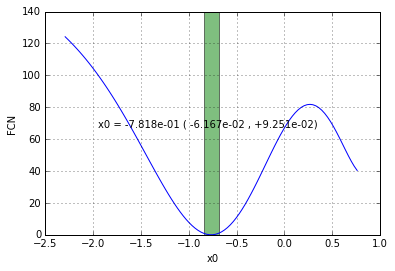

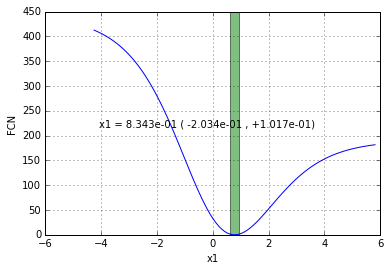

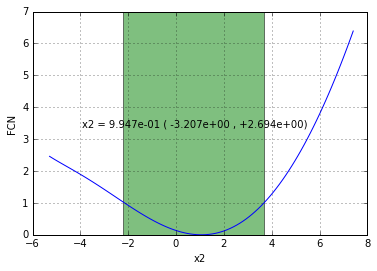

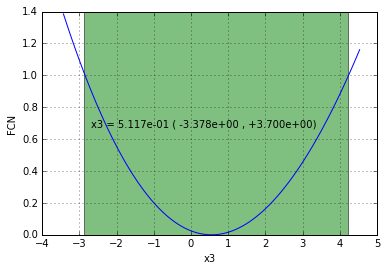

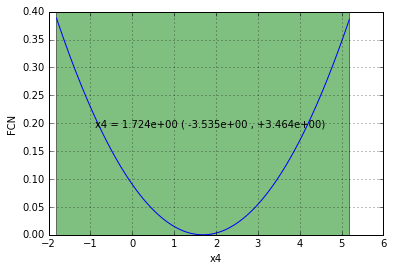

In [411]:
#1D value Scan
for i in range(xm.shape[1]):
    plt.figure()
    m.draw_profile('x%d' % i); 

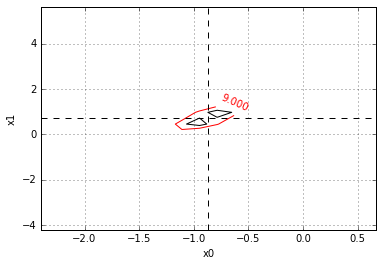

In [375]:
#2d contour NOT minos contour
m.draw_contour('x0','x1');